In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2025-08-09 03:30:36.134862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754710236.157679    2445 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754710236.165197    2445 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 40 classes:
 - Japanese B Encephalitis or Epstein-Barr Encephalitis
 - Inferior Vena Cava (IVC) Leiomyosarcoma
 - Two-Week Follow-Up with Spectroscopy
 - Magnetic Resonance (MR) Spine
 - Congenital Vaginal Cyst
 - Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis
 - Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration)
 - Walker-Warburg Syndrome
 - Tuberous Sclerosis
 - Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis
 - Typical Adrenoleukodystrophy
 - Retinoblastoma with Intracranial Spread Along Cranial Nerve
 - Low Medial Insertion of Common Bile Duct with Pancreas Divisum
 - Osmotic Demyelination Syndrome
 - Neurofibromatosis Type 1 (NF1) with Optic Glioma and Intracranial Extension
 - Sural Nerve Neurofibroma
 - Thoracic Outlet Syndrome
 - Carolis Disease
 - Congenital Toxoplasmosis
 - Optic Glioma
 - Balloon Cell Cortical Dysplasia
 - Acute Cerebellitis in HIV
 - Myositis Ossificans Progressiva
 - S

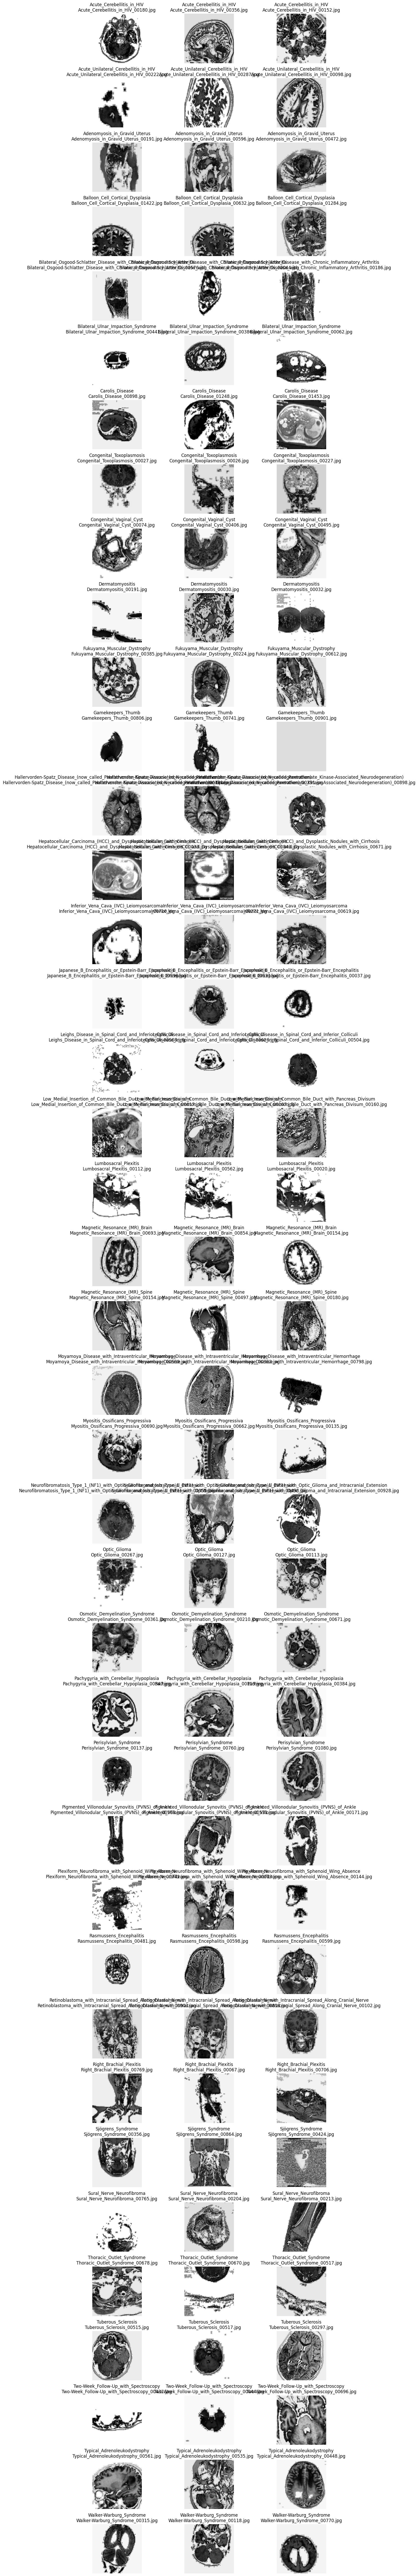

In [2]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

# paths
original_base = Path("/kaggle/input/benchmark/Benchmark Diagnostic MRI and Medical Imaging Dataset/Medical Imaging Dataset")
working_base = Path("/kaggle/working/Medical_Imaging_Cleaned")

# copy data
if working_base.exists():
    shutil.rmtree(working_base)
shutil.copytree(original_base, working_base)

# Finding the class folders
class_folders = []
for root, dirs, files in os.walk(working_base):
    img_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    if img_files:
        class_folders.append(Path(root))

print(f"Found {len(class_folders)} classes:")
for f in class_folders:
    print(" -", f.name)

# pre-process and rename all images 
for class_folder in class_folders:
    class_name = class_folder.name.strip().replace(" ", "_")
    for idx, img_path in enumerate(sorted(class_folder.glob("*"))):
        if not img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.tif', '.tiff']:
            continue
        
        img = cv2.imread(str(img_path))  # Read BGR
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        # Histogram equalization per channel
        channels = cv2.split(img)
        channels = [cv2.equalizeHist(c) for c in channels]
        img = cv2.merge(channels)

        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = cv2.resize(img, (224, 224))

        new_filename = f"{class_name}_{idx:05d}.jpg"
        new_img_path = class_folder / new_filename
        cv2.imwrite(str(new_img_path), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))  # Save in BGR

        if img_path.name != new_filename:
            img_path.unlink()

print(" All images preprocessed and renamed.")

# Verifying
total_images = 0
errors = []
for class_folder in class_folders:
    class_name = class_folder.name.strip().replace(" ", "_")
    for img_path in class_folder.glob("*.jpg"):
        total_images += 1
        if not img_path.name.startswith(class_name + "_"):
            errors.append(f"Wrong filename: {img_path.name}")
        img = cv2.imread(str(img_path))
        if img is None:
            errors.append(f"Unreadable image: {img_path.name}")
            continue
        if img.shape != (224, 224, 3):
            errors.append(f"Wrong shape {img.shape} in: {img_path.name}")

print(f"\n Verified {total_images} images.")
if errors:
    print(f" Found {len(errors)} issue(s):")
    for err in errors[:10]:
        print(" -", err)
    if len(errors) > 10:
        print("... more issues omitted.")
else:
    print(" All images verified successfully!")

# Display sample images 
print("\n Displaying sample images from each class...")
samples_per_class = 3
fig, axs = plt.subplots(len(class_folders), samples_per_class, figsize=(12, 2.5 * len(class_folders)))

for i, class_folder in enumerate(sorted(class_folders)):
    class_name = class_folder.name.strip().replace(" ", "_")
    all_images = list(class_folder.glob("*.jpg"))
    sample_images = random.sample(all_images, min(samples_per_class, len(all_images)))
    for j, img_path in enumerate(sample_images):
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        axs[i, j].set_title(f"{class_name}\n{img_path.name}")

plt.tight_layout()
plt.show()


In [3]:
import os
import random
from pathlib import Path
from shutil import move
from collections import defaultdict
from tqdm import tqdm

random.seed(42)

# Base path to the benchmark dataset 
base_dir = Path('/kaggle/working/Medical_Imaging_Cleaned')

split_base = Path('/kaggle/working/Benchmark_split')
train_dir = split_base / 'train'
val_dir = split_base / 'val'
test_dir = split_base / 'test'

for split in [train_dir, val_dir, test_dir]:
    split.mkdir(parents=True, exist_ok=True)

split_counts = defaultdict(lambda: defaultdict(int))

print("Splitting dataset into train (70%), val (10%), test (20%)...\n")

for class_dir in tqdm(sorted(base_dir.iterdir())):
    if not class_dir.is_dir():
        continue

    label = class_dir.name

    # Recursively find all images inside this class folder
    all_images = list(class_dir.rglob("*.jpg")) + list(class_dir.rglob("*.png")) + list(class_dir.rglob("*.jpeg"))

    if len(all_images) == 0:
        print(f" No images found in: {label}")
        continue

    random.shuffle(all_images)

    total = len(all_images)
    n_train = int(0.7 * total)
    n_val = int(0.1 * total)
    n_test = total - n_train - n_val

    split_sets = {
        train_dir / label: all_images[:n_train],
        val_dir / label: all_images[n_train:n_train + n_val],
        test_dir / label: all_images[n_train + n_val:]
    }

    for split_path, images in split_sets.items():
        split_path.mkdir(parents=True, exist_ok=True)
        for img_path in images:
            move(str(img_path), str(split_path / img_path.name))
            split_counts[split_path.parent.name][label] += 1

print("\n Dataset split completed.")
print("Image counts per class in each split:")

for split in ['train', 'val', 'test']:
    print(f"\n {split.upper()} set:")
    total = 0
    for label, count in sorted(split_counts[split].items()):
        print(f"  {label:20s}: {count}")
        total += count
    print(f"  {'Total':20s}: {total}")


Splitting dataset into train (70%), val (10%), test (20%)...



100%|██████████| 40/40 [00:02<00:00, 19.28it/s]


 Dataset split completed.
Image counts per class in each split:

 TRAIN set:
  Acute Cerebellitis in HIV: 683
  Acute Unilateral Cerebellitis in HIV: 341
  Adenomyosis in Gravid Uterus: 548
  Balloon Cell Cortical Dysplasia: 996
  Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis: 459
  Bilateral Ulnar Impaction Syndrome: 414
  Carolis Disease     : 1024
  Congenital Toxoplasmosis: 448
  Congenital Vaginal Cyst: 386
  Dermatomyositis     : 403
  Fukuyama Muscular Dystrophy: 644
  Gamekeepers Thumb   : 683
  Hallervorden-Spatz Disease (now called Pantothenate Kinase-Associated Neurodegeneration): 744
  Hepatocellular Carcinoma (HCC) and Dysplastic Nodules with Cirrhosis: 694
  Inferior Vena Cava (IVC) Leiomyosarcoma-20240916T165709Z-001: 627
  Japanese B Encephalitis or Epstein-Barr Encephalitis: 806
  Leighs Disease in Spinal Cord and Inferior Colliculi: 638
  Low Medial Insertion of Common Bile Duct with Pancreas Divisum-20240916T165825Z-001: 503
  Lumbosacral Pl

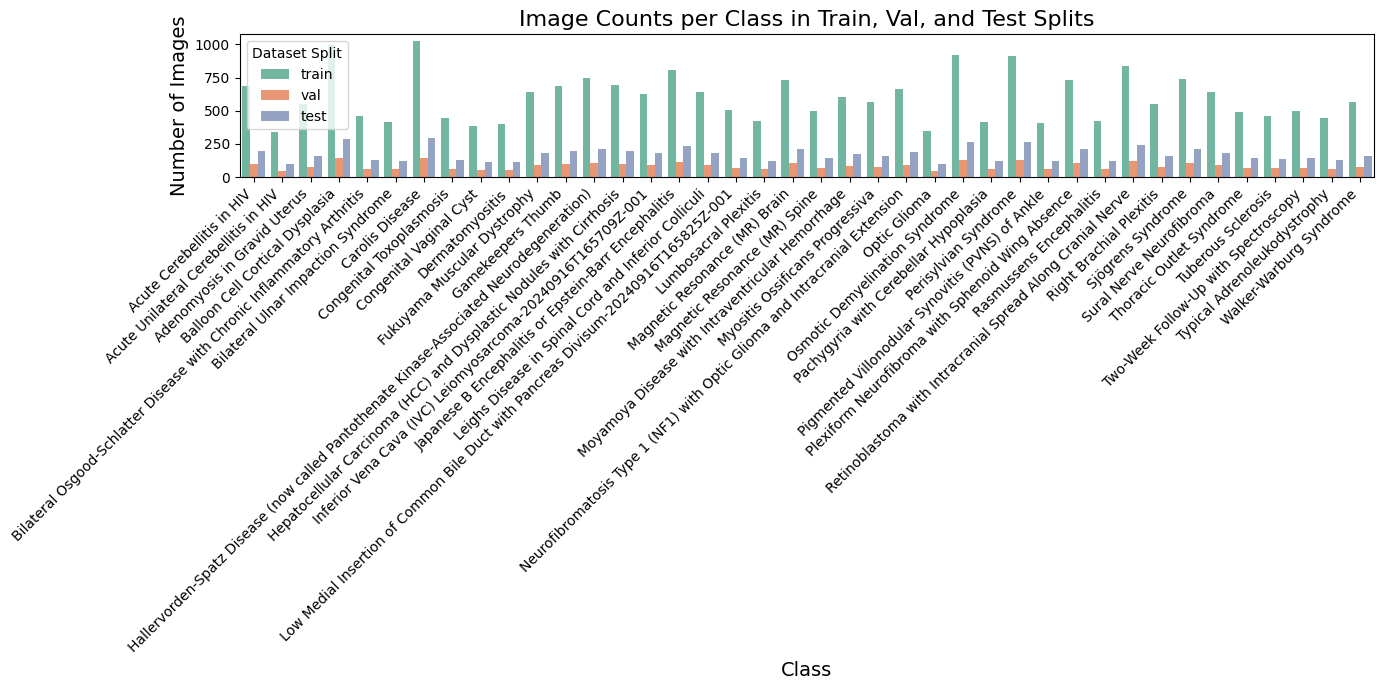

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# split_counts[split][label] 
data = []
for split in ['train', 'val', 'test']:
    for label, count in split_counts[split].items():
        data.append({"Class": label, "Split": split, "Count": count})

df_counts = pd.DataFrame(data)

# sub divided bar graph
plt.figure(figsize=(14, 7))
sns.barplot(data=df_counts, x="Class", y="Count", hue="Split", palette="Set2")

plt.title("Image Counts per Class in Train, Val, and Test Splits", fontsize=16)
plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.legend(title="Dataset Split")
plt.tight_layout()
plt.show()


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import numpy as np
from tqdm import tqdm
from pathlib import Path
from torchvision import transforms

In [6]:
from pathlib import Path
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# path
data_path = Path('/kaggle/working/Benchmark_split')

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Faster processing, compatible with pretrained CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean/std
                         std=[0.229, 0.224, 0.225])
])

# Load datasets
train_data = datasets.ImageFolder(data_path / "train", transform=transform)
val_data = datasets.ImageFolder(data_path / "val", transform=transform)
test_data = datasets.ImageFolder(data_path / "test", transform=transform)

# Dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Number of classes
num_classes = len(train_data.classes)

# Optional check
print(f" Total bird species (classes): {num_classes}")
print(f" Example classes: {train_data.classes[:5]}")


 Total bird species (classes): 40
 Example classes: ['Acute Cerebellitis in HIV', 'Acute Unilateral Cerebellitis in HIV', 'Adenomyosis in Gravid Uterus', 'Balloon Cell Cortical Dysplasia', 'Bilateral Osgood-Schlatter Disease with Chronic Inflammatory Arthritis']


###############################   RESNET

In [7]:
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [9]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Hyperparameter options
learning_rates = [1e-3, 1e-4]
optimizers = ['adam', 'sgd']
patience = 5        # Number of epochs with no improvement before stopping
max_epochs = 100    # Safety cap to avoid infinite loop
best_val_acc = 0.0
best_model = None

for lr in learning_rates:
    for opt in optimizers:
        print(f"\n Trying: LR={lr}, Optimizer={opt.upper()}")

        # Load pretrained ResNet18
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model = model.to(device)

        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Optimizer
        if opt == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif opt == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

        # Early stopping variables
        epochs_no_improve = 0

        for epoch in range(max_epochs):
            print(f" Epoch {epoch+1}")
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = validate(model, val_loader, criterion)

            # Append for plotting
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)

            print(f" Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
            print(f" Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

            # Check improvement
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                torch.save(model.state_dict(), "/kaggle/working/best_resnet18.pth")
                print(" Best model saved.")
                epochs_no_improve = 0  # Reset counter
            else:
                epochs_no_improve += 1
                print(f" No improvement for {epochs_no_improve} epoch(s).")

            # Early stopping
            if epochs_no_improve >= patience:
                print(" Early stopping triggered!")
                break

print(f"\n Best Validation Accuracy: {best_val_acc:.4f}")



 Trying: LR=0.001, Optimizer=ADAM


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Epoch 1


 Train Loss: 0.9756, Acc: 0.6915
 Val   Loss: 0.7340, Acc: 0.7556
 Best model saved.
 Epoch 2


 Train Loss: 0.3475, Acc: 0.8670
 Val   Loss: 0.7027, Acc: 0.7750
 Best model saved.
 Epoch 3


 Train Loss: 0.2342, Acc: 0.9016
 Val   Loss: 0.4681, Acc: 0.8308
 Best model saved.
 Epoch 4


 Train Loss: 0.1843, Acc: 0.9189
 Val   Loss: 0.7328, Acc: 0.7858
 No improvement for 1 epoch(s).
 Epoch 5


 Train Loss: 0.1851, Acc: 0.9180
 Val   Loss: 0.3727, Acc: 0.8702
 Best model saved.
 Epoch 6


 Train Loss: 0.1483, Acc: 0.9313
 Val   Loss: 0.3509, Acc: 0.8649
 No improvement for 1 epoch(s).
 Epoch 7


 Train Loss: 0.1562, Acc: 0.9296
 Val   Loss: 0.4254, Acc: 0.8558
 No improvement for 2 epoch(s).
 Epoch 8


 Train Loss: 0.1326, Acc: 0.9399
 Val   Loss: 0.3435, Acc: 0.8810
 Best model saved.
 Epoch 9


 Train Loss: 0.1179, Acc: 0.9455
 Val   Loss: 0.2643, Acc: 0.8978
 Best model saved.
 Epoch 10


 Train Loss: 0.1217, Acc: 0.9478
 Val   Loss: 0.7264, Acc: 0.7938
 No improvement for 1 epoch(s).
 Epoch 11


 Train Loss: 0.1317, Acc: 0.9445
 Val   Loss: 0.3570, Acc: 0.8807
 No improvement for 2 epoch(s).
 Epoch 12


 Train Loss: 0.0855, Acc: 0.9620
 Val   Loss: 0.2570, Acc: 0.9080
 Best model saved.
 Epoch 13


 Train Loss: 0.0939, Acc: 0.9614
 Val   Loss: 0.2710, Acc: 0.9060
 No improvement for 1 epoch(s).
 Epoch 14


 Train Loss: 0.0851, Acc: 0.9662
 Val   Loss: 0.3370, Acc: 0.8890
 No improvement for 2 epoch(s).
 Epoch 15


 Train Loss: 0.0950, Acc: 0.9640
 Val   Loss: 0.3783, Acc: 0.8901
 No improvement for 3 epoch(s).
 Epoch 16


 Train Loss: 0.0533, Acc: 0.9786
 Val   Loss: 0.3369, Acc: 0.8981
 No improvement for 4 epoch(s).
 Epoch 17


 Train Loss: 0.0890, Acc: 0.9667
 Val   Loss: 0.3584, Acc: 0.8887
 No improvement for 5 epoch(s).
 Early stopping triggered!

 Trying: LR=0.001, Optimizer=SGD
 Epoch 1


 Train Loss: 2.1268, Acc: 0.4593
 Val   Loss: 1.2260, Acc: 0.6818
 No improvement for 1 epoch(s).
 Epoch 2


 Train Loss: 0.8799, Acc: 0.7773
 Val   Loss: 0.6895, Acc: 0.8123
 No improvement for 2 epoch(s).
 Epoch 3


 Train Loss: 0.4987, Acc: 0.8699
 Val   Loss: 0.4698, Acc: 0.8546
 No improvement for 3 epoch(s).
 Epoch 4


 Train Loss: 0.3194, Acc: 0.9125
 Val   Loss: 0.3474, Acc: 0.8895
 No improvement for 4 epoch(s).
 Epoch 5


 Train Loss: 0.2227, Acc: 0.9369
 Val   Loss: 0.2871, Acc: 0.9045
 No improvement for 5 epoch(s).
 Early stopping triggered!

 Trying: LR=0.0001, Optimizer=ADAM
 Epoch 1


 Train Loss: 1.1006, Acc: 0.7172
 Val   Loss: 0.3595, Acc: 0.8931
 No improvement for 1 epoch(s).
 Epoch 2


 Train Loss: 0.2117, Acc: 0.9292
 Val   Loss: 0.2188, Acc: 0.9216
 Best model saved.
 Epoch 3


 Train Loss: 0.1055, Acc: 0.9558
 Val   Loss: 0.1758, Acc: 0.9271
 Best model saved.
 Epoch 4


 Train Loss: 0.0834, Acc: 0.9649
 Val   Loss: 0.1827, Acc: 0.9236
 No improvement for 1 epoch(s).
 Epoch 5


 Train Loss: 0.0651, Acc: 0.9740
 Val   Loss: 0.1874, Acc: 0.9263
 No improvement for 2 epoch(s).
 Epoch 6


 Train Loss: 0.0503, Acc: 0.9813
 Val   Loss: 0.1971, Acc: 0.9283
 Best model saved.
 Epoch 7


 Train Loss: 0.0488, Acc: 0.9837
 Val   Loss: 0.3092, Acc: 0.8922
 No improvement for 1 epoch(s).
 Epoch 8


 Train Loss: 0.0541, Acc: 0.9833
 Val   Loss: 0.2636, Acc: 0.9133
 No improvement for 2 epoch(s).
 Epoch 9


 Train Loss: 0.0352, Acc: 0.9880
 Val   Loss: 0.2491, Acc: 0.9245
 No improvement for 3 epoch(s).
 Epoch 10


 Train Loss: 0.0228, Acc: 0.9921
 Val   Loss: 0.2816, Acc: 0.9230
 No improvement for 4 epoch(s).
 Epoch 11


 Train Loss: 0.0260, Acc: 0.9921
 Val   Loss: 0.4060, Acc: 0.8869
 No improvement for 5 epoch(s).
 Early stopping triggered!

 Trying: LR=0.0001, Optimizer=SGD
 Epoch 1


 Train Loss: 3.4642, Acc: 0.1178
 Val   Loss: 3.1340, Acc: 0.2335
 No improvement for 1 epoch(s).
 Epoch 2


 Train Loss: 2.8794, Acc: 0.3053
 Val   Loss: 2.6371, Acc: 0.3678
 No improvement for 2 epoch(s).
 Epoch 3


 Train Loss: 2.4437, Acc: 0.4103
 Val   Loss: 2.2748, Acc: 0.4492
 No improvement for 3 epoch(s).
 Epoch 4


 Train Loss: 2.1212, Acc: 0.4817
 Val   Loss: 2.0096, Acc: 0.5059
 No improvement for 4 epoch(s).
 Epoch 5


 Train Loss: 1.8768, Acc: 0.5360
 Val   Loss: 1.7890, Acc: 0.5567
 No improvement for 5 epoch(s).
 Early stopping triggered!

 Best Validation Accuracy: 0.9283


In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# load the best model
best_model = models.resnet18(pretrained=False)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)
best_model.load_state_dict(torch.load("/kaggle/working/best_resnet18.pth"))
best_model = best_model.to(device)
best_model.eval()

# evaluate on test set
all_preds, all_labels, all_probs = [], [], []
test_loss, total_samples = 0.0, 0
criterion = torch.nn.CrossEntropyLoss()

start_time = time.time()  # Start timing

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing"):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)

        # Probabilities for metrics like std dev, ROC
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        total_samples += labels.size(0)

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

end_time = time.time()  # End timing
prediction_time = end_time - start_time  # Total time in seconds

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# evaluation metirc
acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
cross_entropy = test_loss / total_samples
std_dev = np.std(all_probs, axis=0).mean()  # avg std across classes

# Sensitivity 
cm = confusion_matrix(all_labels, all_preds)
sensitivity_per_class = cm.diagonal() / cm.sum(axis=1)
sensitivity = np.mean(sensitivity_per_class)

print(f"\n Test Accuracy       : {acc:.4f}")
print(f" Macro F1 Score     : {f1:.4f}")
print(f" Macro Precision    : {precision:.4f}")
print(f" Macro Recall       : {recall:.4f}")
print(f" Sensitivity        : {sensitivity:.4f}")
print(f" Cross Entropy Loss : {cross_entropy:.4f}")
print(f" Std. Dev of probs  : {std_dev:.4f}")
print(f" Prediction Time    : {prediction_time:.4f} seconds")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testing: 100%|██████████| 108/108 [00:07<00:00, 13.64it/s]


 Test Accuracy       : 0.9176
 Macro F1 Score     : 0.9087
 Macro Precision    : 0.9089
 Macro Recall       : 0.9089
 Sensitivity        : 0.9089
 Cross Entropy Loss : 0.2040
 Std. Dev of probs  : 0.1469
 Prediction Time    : 7.9211 seconds


In [11]:
from sklearn.metrics import classification_report
import pandas as pd
report_dict = classification_report(
    all_labels, all_preds, target_names=train_data.classes, output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose().round(4)

styled_report = (
    report_df.style
    .background_gradient(cmap="Blues")  
    .format(precision=6)                
)

print("\n Classification Report:")
display(styled_report)


 Classification Report:


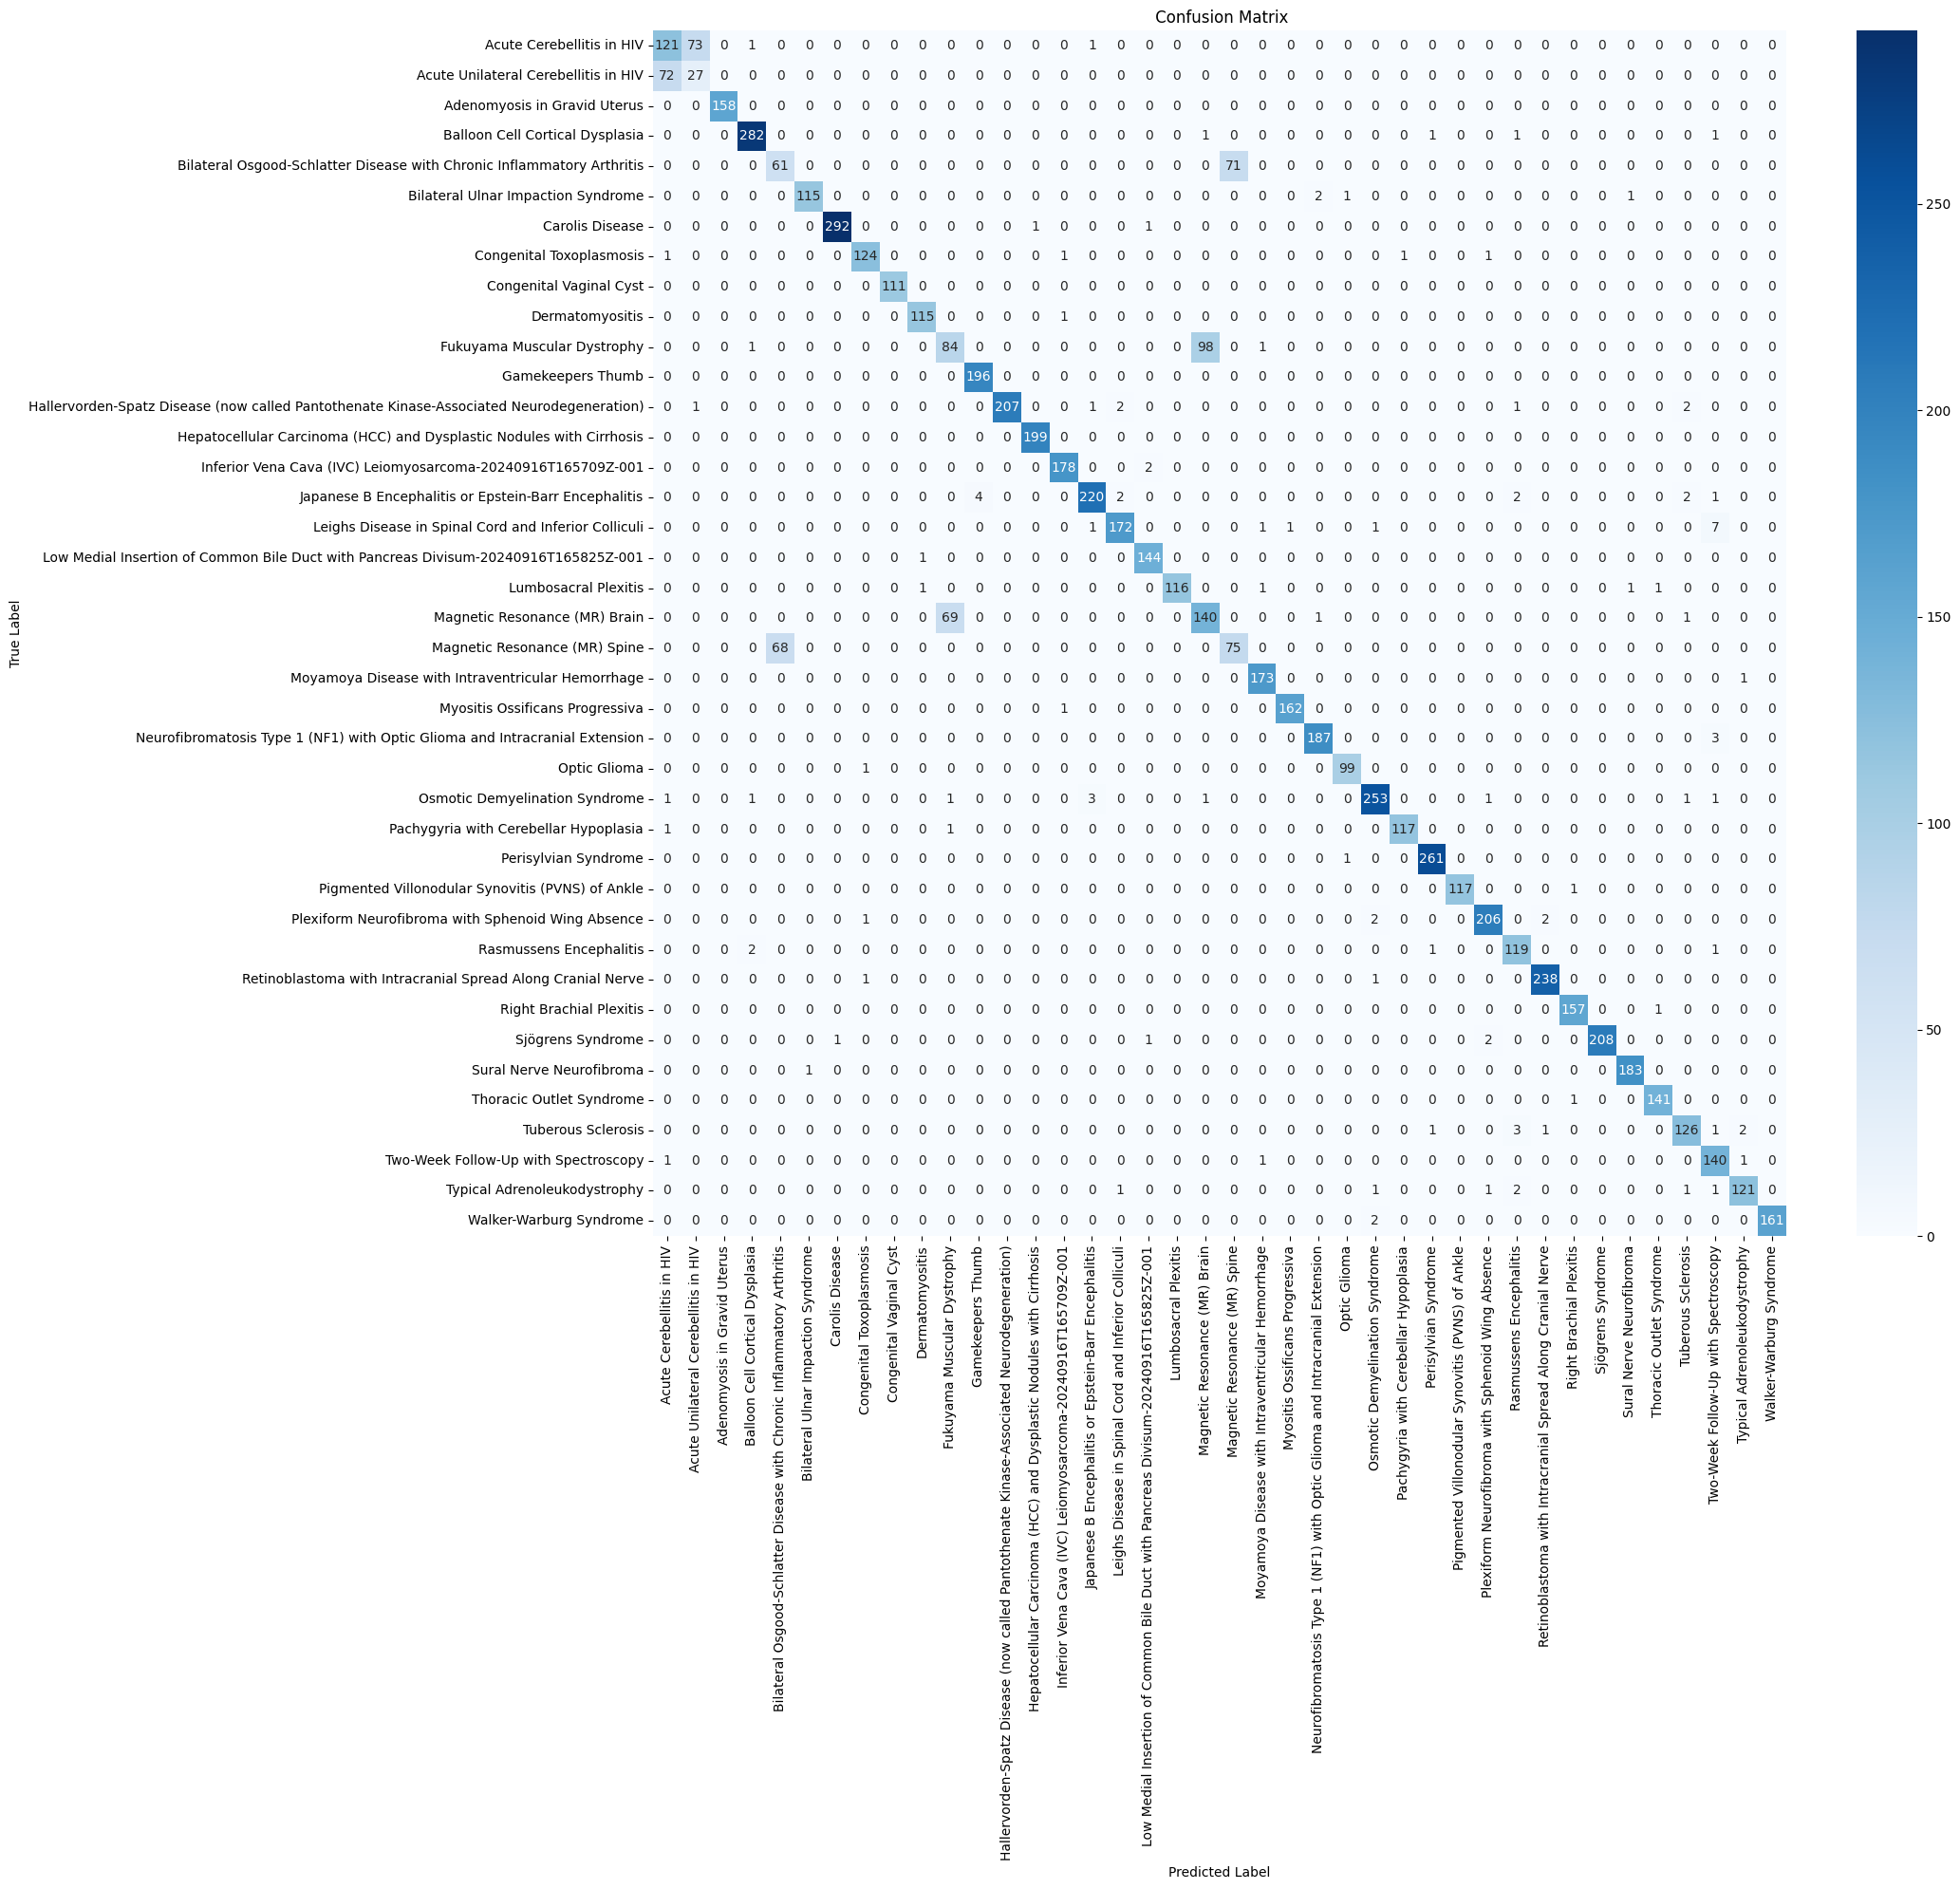

In [12]:
# confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(22, 20))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.title(" Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

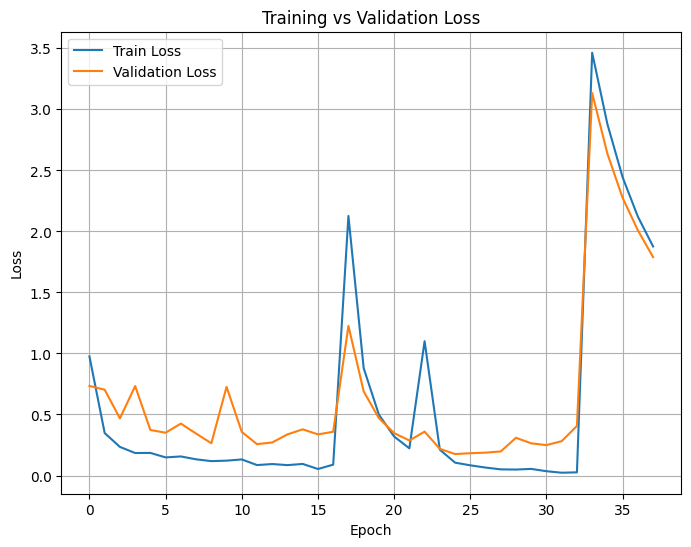

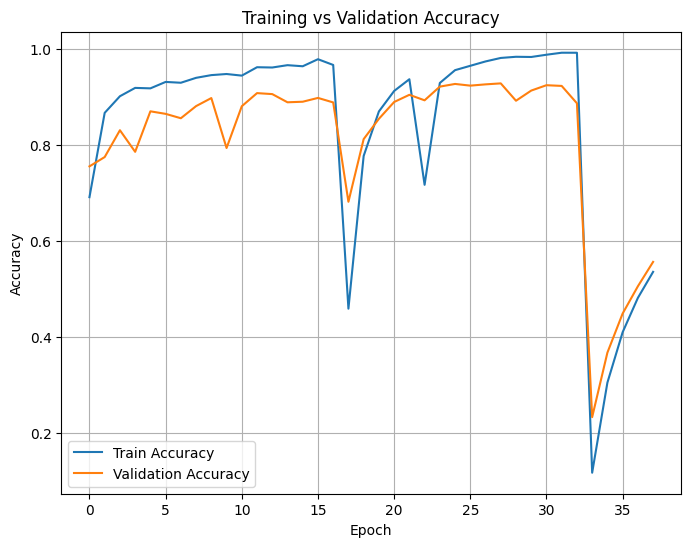

In [13]:
# loss and accuracy graphs
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

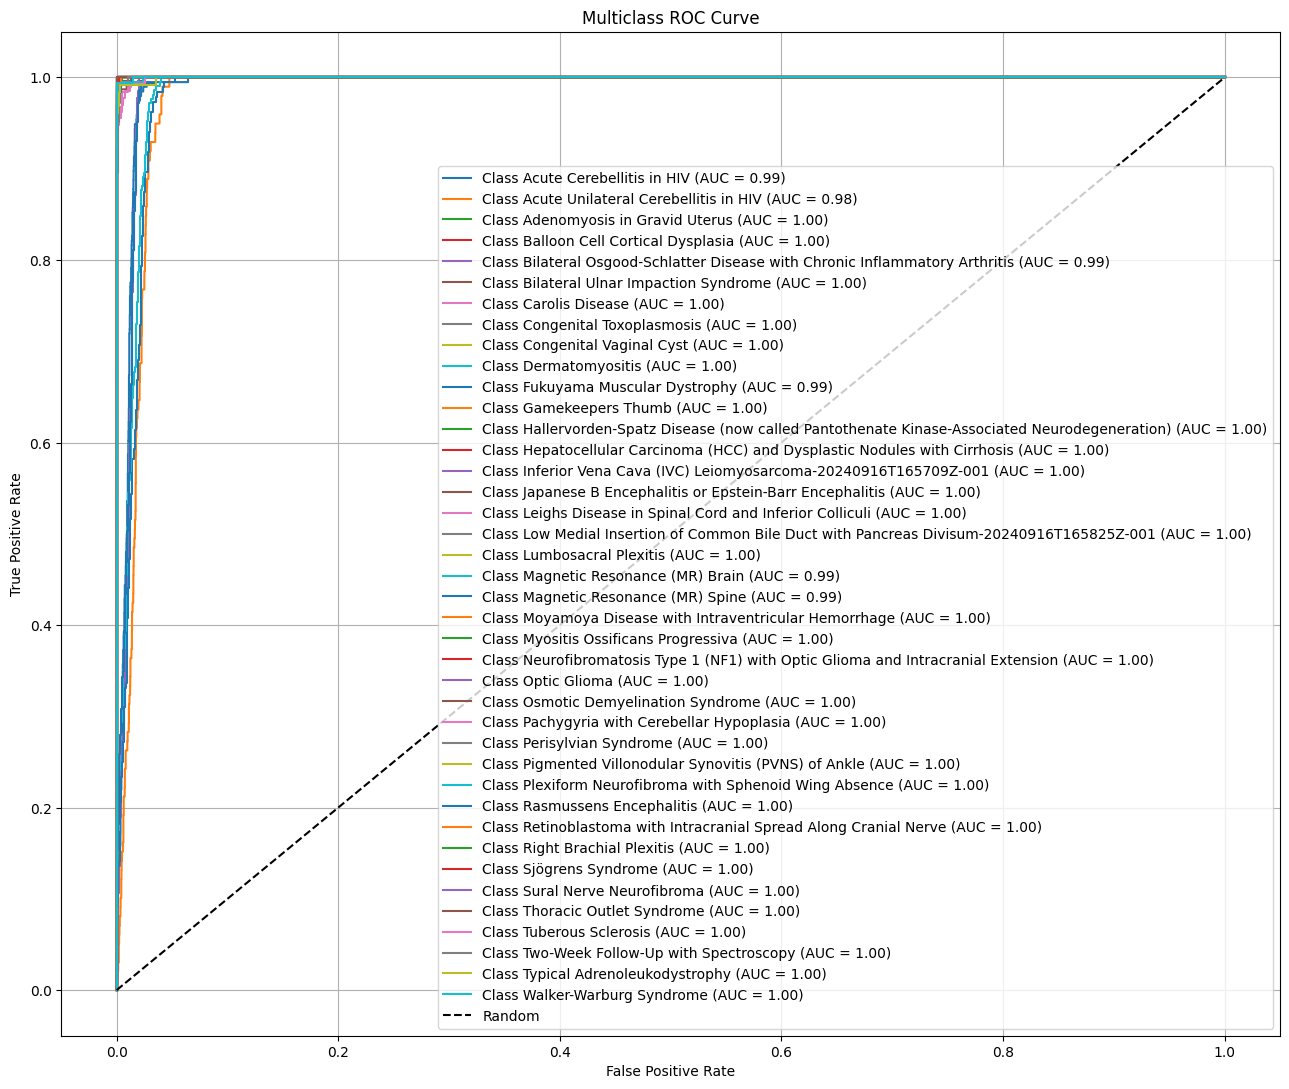

In [14]:
from sklearn.preprocessing import label_binarize
n_classes = len(np.unique(all_labels))
y_test_bin = label_binarize(all_labels, classes=list(range(n_classes)))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(13, 11))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {train_data.classes[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()